<a href="https://colab.research.google.com/github/AgSanches/DogSorter/blob/master/CNN_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dogs Sorter

This program allow us to distinguish 9 different types of dogs, for make this program I have used [Stanford Dogs Dataset](https://www.kaggle.com/jessicali9530/stanford-dogs-dataset),.

In [0]:
#Load Libraries
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread

import keras
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from keras.layers import GaussianNoise

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
images = []
labels = []
imgsize = 200
image_path = '/content/drive/My Drive/Colab Notebooks/datasets/perros/images'

for root, dirnames, filenames in os.walk(image_path):
  print("Leyendo -> {} ".format(root))
  for filenames in filenames:
    label = os.path.basename(root)
    path = os.path.join(root,filenames)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img,(imgsize,imgsize))
    images.append(np.array(img))
    labels.append(str(label))

print("Total de imágenes: {}".format(len(images)))
print("Total de categorías: {}".format(len(np.unique(labels))))


Leyendo -> /content/drive/My Drive/Colab Notebooks/datasets/perros/images 
Leyendo -> /content/drive/My Drive/Colab Notebooks/datasets/perros/images/n02085620-Chihuahua 
Leyendo -> /content/drive/My Drive/Colab Notebooks/datasets/perros/images/n02086240-Shih-Tzu 
Leyendo -> /content/drive/My Drive/Colab Notebooks/datasets/perros/images/n02106662-German_shepherd 
Leyendo -> /content/drive/My Drive/Colab Notebooks/datasets/perros/images/n02110185-Siberian_husky 
Leyendo -> /content/drive/My Drive/Colab Notebooks/datasets/perros/images/n02088364-beagle 
Leyendo -> /content/drive/My Drive/Colab Notebooks/datasets/perros/images/n02108915-French_bulldog 
Leyendo -> /content/drive/My Drive/Colab Notebooks/datasets/perros/images/n02108422-bull_mastiff 
Leyendo -> /content/drive/My Drive/Colab Notebooks/datasets/perros/images/n02089973-English_foxhound 
Leyendo -> /content/drive/My Drive/Colab Notebooks/datasets/perros/images/n02093256-Staffordshire_bullterrier 
Total de imágenes: 1532
Total de

In [0]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(labels)
Y = to_categorical(Y,len(np.unique(labels)))
X = np.array(images)
X= X/255

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=34)

In [0]:
bs_train = 60
bs_valid = 130

images_gen = ImageDataGenerator(featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.4, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

images_gen.fit(x_train)

images_gen_valid = ImageDataGenerator(featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.4, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

images_gen_valid.fit(x_test)

train_gen = images_gen.flow(x_train,y_train,batch_size=bs_train)
valid_gen = images_gen_valid.flow(x_test,y_test,batch_size=bs_valid)

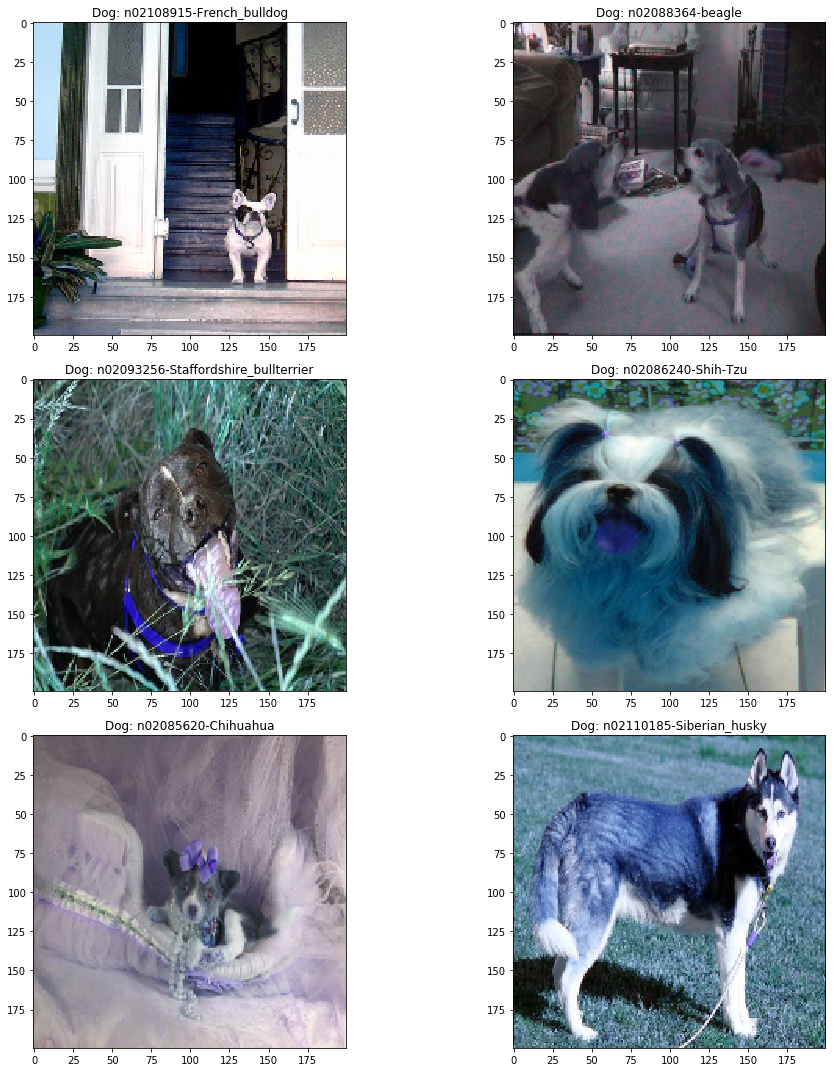

In [0]:
fig,ax=plt.subplots(3,2)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (2):
        l=rn.randint(0,len(labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Dog: '+labels[l])
        
plt.tight_layout()

###Model

I have used the [VGG16](https://neurohive.io/en/popular-networks/vgg16/) model, this model is great to class different types of objects, I have changed the input shape to 200x200x3 and I have load the weights from imagenet. For the fully-connected layer, I added a couple dense layers of 2048 neurons each

In [0]:
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.4))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(9,activation='softmax'))
model.summary()

opt1 = Adam(lr=1e-1)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 6, 6, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 2048)              37750784  
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2048)              4196352   
__________

In [0]:
vs = (valid_gen.n//valid_gen.batch_size)
spe = (train_gen.n//train_gen.batch_size)

history = model.fit_generator(
    train_gen,
    validation_data = valid_gen,
    validation_steps = vs,
    steps_per_epoch  = spe,
    epochs = 70
) 

Epoch 1/70
15/15 [==============================] - 14s 935ms/step - loss: 5.6481 - acc: 0.1059 - val_loss: 2.1777 - val_acc: 0.1408
Epoch 2/70
15/15 [==============================] - 11s 728ms/step - loss: 2.2504 - acc: 0.1126 - val_loss: 2.1818 - val_acc: 0.1408
Epoch 3/70
15/15 [==============================] - 10s 639ms/step - loss: 2.1862 - acc: 0.1695 - val_loss: 2.1311 - val_acc: 0.2319
Epoch 4/70
15/15 [==============================] - 9s 610ms/step - loss: 2.1045 - acc: 0.2240 - val_loss: 2.0375 - val_acc: 0.2526
Epoch 5/70
15/15 [==============================] - 9s 623ms/step - loss: 1.9972 - acc: 0.2452 - val_loss: 1.8532 - val_acc: 0.2904
Epoch 6/70
15/15 [==============================] - 9s 601ms/step - loss: 1.8806 - acc: 0.2977 - val_loss: 1.7383 - val_acc: 0.3789
Epoch 7/70
15/15 [==============================] - 9s 619ms/step - loss: 1.7400 - acc: 0.3612 - val_loss: 1.6955 - val_acc: 0.3768
Epoch 8/70
15/15 [==============================] - 9s 607ms/step - loss:

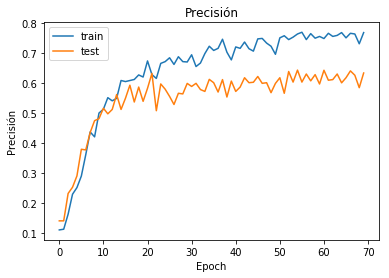

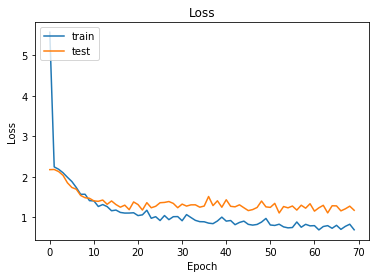

In [0]:
#Precisión
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Precisión')
plt.ylabel('Precisión')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()